In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import special
import numpy as np
import pandas as pd

import os
import glob
import itertools as it
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
src = '../hpcc/'
dst = '../hpcc/traditional/'

wsrc = src + 'clean/'
tsrc = src + 'watershed/'
rsrc = src + 'rotated/'
ksrc = src + 'kernel/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

In [3]:
idname = '2014SBa'

rownum = 5
treenum = 49
nutnum = 8

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
    
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')
tissuefiles = tsrc + bname + '/' + fname + '_'
air  = tf.imread(tissuefiles + 'air.tif')
meat = tf.imread(tissuefiles + 'meat.tif')
shell= tf.imread(tissuefiles + 'shell.tif')
vein = tf.imread(tissuefiles + 'vein.tif')
protrusion = tf.imread(tissuefiles + 'protrusion.tif')
extshell = np.zeros_like(shell, dtype=np.bool)
extshell[protrusion == 3] = True

2014SBa_R5_T49_008
2014SBa_R5_T49_008


# Relative densities

In [4]:
raw_src = '../raw/'
raw_file = raw_src + bname + '/{:03d}.tif'.format(nutnum)
print(raw_file)
raw = tf.imread(raw_file)

zerofile = wsrc + bname + '/normalization/clean_zeroes{:03d}.csv'.format(nutnum)
cero = np.loadtxt(zerofile, dtype=int)
raw = raw[cero[1]:cero[4], cero[2]:cero[5], cero[0]:cero[3]]

../raw/2014SBa_R5_T49/008.tif


In [5]:
raw_meat = raw.copy()
raw_meat[meat == 0] = 0

raw_shell = raw.copy()
raw_shell[shell == 0] = 0

raw_vein = raw.copy()
raw_vein[vein == 0] = 0

maxval = np.max(raw)

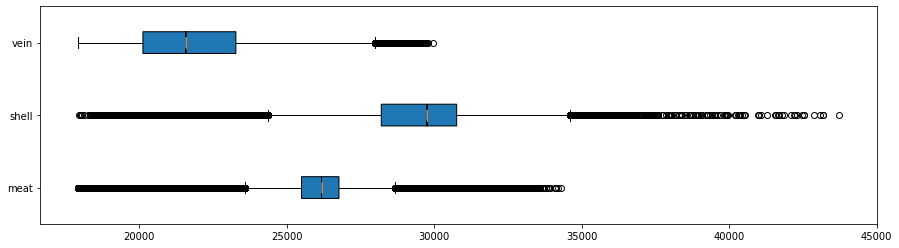

In [6]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
ax = np.atleast_1d(ax).ravel()

idx=0
boxes = [ raw_meat[raw_meat > 0], raw_shell[raw_shell > 0], raw_vein[raw_vein > 0] ]
labels = ['meat','shell','vein']
ax[idx].boxplot(boxes, notch=True, vert=False, patch_artist=True, labels=labels);

In [7]:
rho_meat = np.mean(raw_meat[raw_meat > 0])
rho_shell = np.mean(raw_shell[raw_shell > 0])
rho_vein = np.mean(raw_vein[raw_vein > 0])

q50_meat = np.median(raw_meat[raw_meat > 0])
q50_shell = np.median(raw_shell[raw_shell > 0])
q50_vein = np.median(raw_vein[raw_vein > 0])

rho_mvs = rho_meat/rho_shell
rho_vvs = rho_vein/rho_shell
rho_vvm = rho_vein/rho_meat

print(maxval, rho_meat, rho_shell, rho_vein, sep='\t')
print(maxval, q50_meat, q50_shell, q50_vein, sep='\t')
print(rho_mvs, rho_vvs, rho_vvm, sep='\t')

43724	25953.05153002096	29246.33810175074	21813.706667596798
43724	26178.0	29755.0	21577.0
0.8873949087139685	0.7458611259879742	0.8405064291713054


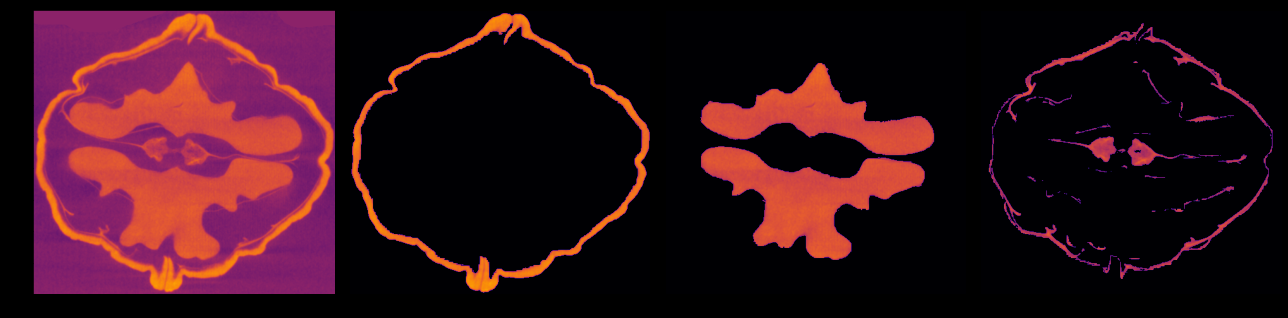

In [8]:
k = 240
fig, ax = plt.subplots(1,4,figsize=(18,5), sharex=True, sharey=True, facecolor='k')
ax =np.atleast_1d(ax).ravel()
ss = np.s_[k,:,:]
i = 0
ax[i].imshow(raw[ss], vmax=maxval, vmin=0, cmap='inferno'); i+=1
ax[i].imshow(raw_shell[ss], vmax=maxval, vmin=0, cmap='inferno'); i+=1
ax[i].imshow(raw_meat[ss], vmax=maxval, vmin=0, cmap='inferno'); i+=1
ax[i].imshow(raw_vein[ss], vmax=maxval, vmin=0, cmap='inferno'); i+=1

fig.tight_layout();

### Load rotations and phenotypes

In [9]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
#nutvoxarea *= resol**2
chnutarea, chnutvol, _ = data[20]

tipvox[0] *= 1 + (-2*rotX)

chnutaratio = chnutarea/nutarea
chnutvratio = chnutvol/nutvol

In [10]:
print('Feret:\t', np.round(feretd,1), '\n')
print('*****', 'A[mm^2]', 'V[mm^3]', sep='\t')
print('Walnut', np.round(nutarea), np.round(nutvol), sep='\t')
print('Hull', np.round(chnutarea), np.round(chnutvol), sep='\t')
print('Hull/W', np.round(chnutaratio,3), np.round(chnutvratio,3), sep='\t')
####
print('\nVol Approx by a box of side:\t', np.round(np.cbrt(nutvol),2), 'mm')
print('Vol Approx by a ball of diam:\t', np.round(2*np.cbrt(3*nutvol/(4*np.pi)),2), 'mm')
####
print('\nArea Approx by a box of side:\t', np.round(np.sqrt(nutarea/6),2), 'mm')
print('Area Approx by a ball of diam:\t', np.round(2*np.sqrt(nutarea/(4*np.pi)),2), 'mm')

Feret:	 [43.3 35.7 34. ] 

*****	A[mm^2]	V[mm^3]
Walnut	6732.0	22633.0
Hull	4212.0	24598.0
Hull/W	0.626	1.087

Vol Approx by a box of side:	 28.29 mm
Vol Approx by a ball of diam:	 35.1 mm

Area Approx by a box of side:	 33.5 mm
Area Approx by a ball of diam:	 46.29 mm


### Other phenotypes

In [11]:
tvols = np.zeros(4)
for i,tissue in enumerate([air, meat, shell, vein]):
    tvols[i] = np.sum(tissue > 0)

tvols = tvols.astype(float)*(resol**3)

tvolr = tvols/nutvol
print(np.round(tvolr*100,2), np.round(np.sum(tvolr)), sep='\n')

[41.16 33.54 16.19  9.11]
1.0


### Sphericity

In [12]:
nutva3d = (nutarea ** 3)/(36*np.pi*nutvol**2)
nutferet = np.max(feretd)/np.min(feretd)
nutsphr = np.cbrt(36 * np.pi * nutvol**2)/nutarea
shellrug = 1./nutsphr

In [13]:
c,b,a = np.sort(feretd)*.5

if a == c:
    area = 4*np.pi*a*a
else:
    t = np.arccos(c/a)
    s = np.arccos(c/b)
    k = np.sin(s)/np.sin(t)

    ellarea = c*c/(a*a)*special.ellipkinc(t, k*k) + np.sin(t)*np.sin(t)*special.ellipeinc(t, k*k)
    ellarea *= 2*np.pi*a*b/np.sin(t)
    ellarea += 2*np.pi*c*c

ellvolume = 4*np.pi*a*b*c/3
wwadell = np.cbrt(36*np.pi*ellvolume*ellvolume)/ellarea

wkrumbein = np.cbrt(b*c/(a*a))
wcorey = c/np.sqrt(a*b)
wsneed = np.cbrt(c*c/(a*b))
wjanke = c/np.sqrt((a**2 + b**2 + c**2)/3)
wequancy = c/a

print('{:.2f}\t{:.2f}\t{:.2f}'.format(a,b,c))
print(np.round([nutsphr, wwadell, wkrumbein, wcorey, wsneed, wjanke, wequancy],3), sep='\t')

21.64	17.85	17.00
[0.575 0.992 0.865 0.865 0.908 0.898 0.786]


## Kernel phenotypes

In [14]:
bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
kerarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
kervoxarea = np.sum(border)

print('Border made of\t', kervoxarea, 'pixels\n')
print('Nut surface area:\t', np.round(kerarea, 2), 'mm^2')
print('Approx by a square of size:\t', np.round(np.sqrt(kerarea),2), 'mm')

datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)
print(kmaxes - kminis)

Border made of	 806000 pixels

Nut surface area:	 7621.29 mm^2
Approx by a square of size:	 87.3 mm
[32.98726462 30.47460356 26.81370068]


In [16]:
khull = spatial.ConvexHull(mcoords.T)
kerlob = khull.area/kerarea
chkervratio = khull.volume/tvols[1]
print(kerlob, 1/kerlob, sep='\t')

0.3909875811757604	2.5576259915796933


In [31]:
filename = ksrc + bname + '/' + fname + '_kernel.csv'
kpheno = pd.read_csv(filename, header=None, dtype={1:str}).values[0][2:].astype(float)

# 0   kerarea
# 1   kervol
# 2   charearatio
# 3   chivolratio
# 4   krumbein
# 5   corey
# 6   sneed
# 7   janke
# 8   c/a
# 9   suf
# 10  vol
# 11  hlength
# 12  alength

kerSR = kpheno[9]/kpheno[0]
kerVR = kpheno[10]/khull.volume
kersphr = np.cbrt(36 * np.pi * kpheno[1]**2)/kpheno[0]

print(kerSR, kerVR, kersphr, sep='\t')

0.0311606896153306	0.0244608366968265	0.2450960038060903


## Shell thickness

In [18]:
reload(wnut)
thickness = wnut.object_thickness(extshell, resol, NNN=4, K=5)[0]
thickness

0.9804934279045016

## Protruding shell

In [26]:
shellvols, _ = np.histogram(protrusion, [2, 4, 6, 10], range=(0,10))
shellvols = np.asarray([shellvols[0], shellvols[1]+shellvols[2]])
shellvols

array([8070993,  308307])

In [27]:
shellvols/np.sum(shellvols)
shellvols*resol**3

array([3529.00520029,  134.80584189])

# Data saving

In [32]:
tradpheno = np.hstack((feretd,
                       nutvol,
                       nutva3d, # rugosity ** 3
                       nutferet,
                       nutarea,
                       nutsphr, # wadell
                       chnutarea,
                       chnutvol,
                       chnutaratio,
                       1./chnutvratio,
                       wkrumbein,
                       wsneed,
                       tvols,
                       tvolr,
                       shellrug, # 1/wadell
                       thickness,
                       shellvols/np.sum(shellvols),
                       shellvols*resol**3,
                       kmaxes - kminis,
                       kerarea,
                       khull.volume,
                       khull.area,
                       kpheno[2:4],
                       kpheno[9:],
                       kersphr,
                       kerSR,
                       kerVR,
                       rho_mvs, rho_vvs, rho_vvm))
print(tradpheno.shape)

filename = wdst + fname + '_trad.csv'
print(filename)
foo = pd.DataFrame([bname, fname.split('_')[-1], *tradpheno]).T
foo

(46,)
../hpcc/traditional/2014SBa_R5_T49/2014SBa_R5_T49_008_trad.csv


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,2014SBa_R5_T49,008,43.2808,35.6993,34.0058,22632.8,5.26518,1.27275,6731.54,0.574816,...,237.485,351.596,11.4911,19.2877,0.245096,0.0311607,0.0244608,0.887395,0.745861,0.840506


In [ ]:
foo.to_csv(filename, header=False, index=False)

In [ ]:
bar = pd.read_csv(filename, header=None, dtype={1:str})

In [ ]:
bar